<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">The Coastal Grain Size Portal (C-GRASP) dataset <br/><em>Will Speiser, Daniel Buscombe, and Evan Goldstein</em></strong><br/><br/>
        <strong>> Categorize Samples by percent sand, percent mud, and percent coarse </strong><br/>
    </p>                       
                
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">The purpose of this notebook</strong>  
    <br/><font color=grey>  This notebook serves as a guide of how to calculate percent cohesive, percent sand, and percent coarse sediment for each sample within a chosen sample dataset.<font><br/>
   <br/><font color=grey> This notebook calls selected data from the CGRASP zenodo repository and runs an iterative function that interpolates the cumulative distribution of each sample, and finds the percentage of samples that are below and above the minimum and wentworth classification of sand sediment grain size in millimeters respectively.<font><br/>
   <br/><font color=grey> The code will compute and add three new fields to the input sample data dataframe for each sample that specifies the percent cohesives,sands, and coarse of the sample composition. To calculate interpolation error or to translate sample data from phi to mm units, see the other notebooks within this repository.<font><br/>   
   <br/><font color=grey> The output of the notebook is a csv with the selected CGRASP dataset and the above three new fields <font><br/>   
    </p>

In [1]:
import pandas as pd
import numpy as np
import scipy
# from scipy.interpolate import interp1d
import ipywidgets
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Choose a dataset

In [2]:
#Dataset collection widget
zen=ipywidgets.Select(
    options=['Entire Dataset', 'Estimated Onshore Data', 'Verified Onshore Data', 'Verified Onshore Post 2012 Data'],
    value='Entire Dataset',
    # rows=10,
    description='Dataset:',
    disabled=False
)

display(zen)

Select(description='Dataset:', options=('Entire Dataset', 'Estimated Onshore Data', 'Verified Onshore Data', '…

#### Download chosen dataset

In [3]:
url = 'https://zenodo.org/record/6099266/files/' 
if zen.value=='Entire Dataset':
    filename='dataset_10kmcoast.csv'
if zen.value=='Estimated Onshore Data':
    filename='Data_EstimatedOnshore.csv'
if zen.value=='Verified Onshore Data':
    filename='Data_VerifiedOnshore.csv'
if zen.value=='Verified Onshore Post 2012 Data':
    filename='Data_Post2012_VerifiedOnshore.csv'
    
print("Downloading {}".format(url+filename))   

In [4]:

url=(url+filename)
print('Retrieving Data, Please Wait')
#retrieve data
df=pd.read_csv(url)
print('Sediment Data Retrieved!') 

Retrieving Data, Please Wait
Sediment Data Retrieved!


#### Specify percentiles

In this cell specifiy the names of the given distributions within the sample data (i.e. d10, d50, d90) within the `percentiles` variable. 

In [5]:
percentiles=str('d10,d16,d25,d50,d65,d75,d84,d90')

#extract percentile values and percentile names that were provided with the source dataset (e.g, 'd50' and .5)
given_dist_vals=[]
given_dist_names=[]

for i in range(0,len((percentiles).split(',',))):
    a=(percentiles).split(',',)[i]
    b=a.split('d')[1]
    val=int(b)/100
    given_dist_names.append(a)
    given_dist_vals.append(val)

#### Calculate percent sand and percent cohesive

Run this cell to calculate percent sand and percent cohesive. 

It will first iterate through each sample and calculate the percent sand via cumulative interpolation. Then it will take the found cumulative percentile for the minimum and maximum wentworth sand grain size (mm) then turn it into a percent fraction and assign the appropriate percent fractions for cohesive, coarse, and sand.

This may take a long time on the full dataset - please consult the waitbar at the bottom of the cell to view progress

In [6]:
for i in tqdm(range(0,(len(df)))):#repeats for each row, aka sample 
    #create an array of distribution grain sizes for each sample 
    grain_size_bins=[]
    #This collects the values from the distributions
    for ia in range(0,len((percentiles).split(',',))):
        bin_size=df[given_dist_names[ia]].iloc[i] 
        grain_size_bins.append(bin_size)
        grain_size_frequencies=given_dist_vals
        
    grain_size_frequencies = np.array(grain_size_frequencies)
    grain_size_bins = np.array(grain_size_bins)

    # find grain size bins in the sand range
    sand_bin_freqs = grain_size_frequencies[(grain_size_bins<=2.0) & (grain_size_bins>.063)]
    
    # if not nan
    if len(sand_bin_freqs)>0:

        # get the range of frequencies covered by sand fraction
        prop_sand = sand_bin_freqs.max() - sand_bin_freqs.min()

        # if that range is the same as the full range, assume 100% sand
        if prop_sand==(np.max(grain_size_frequencies) - np.min(grain_size_frequencies)):
            prop_sand = 1.0
    else:
        prop_sand = np.nan
        
    df.loc[i,["%Sand"]] = 100*prop_sand
    
    # find grain size bins in the cohesive range
    cohesive_bin_freqs = grain_size_frequencies[(grain_size_bins<=.063) & (grain_size_bins>0)]
    
    # if not nan
    if len(cohesive_bin_freqs)>0:

        # get the range of frequencies covered by sand fraction
        prop_cohesive = cohesive_bin_freqs.max() - cohesive_bin_freqs.min()

        # if that range is the same as the full range, assume 100% sand
        if prop_cohesive==(np.max(grain_size_frequencies) - np.min(grain_size_frequencies)):
            prop_cohesive = 1.0
    else:
        prop_cohesive = np.nan
        
    df.loc[i,["%Cohesive"]] = 100*prop_cohesive    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2113/2113 [00:02<00:00, 1041.54it/s]


Compute percentage mud and silt ("cohesive")

Compute percentage gravel ("coarse")

In [7]:
#Remaining percentile is gravel
df['%Coarse']=100-(df["%Sand"]+df['%Cohesive'])

#### Make a quick plot to view distribution of 'percent sand'

(array([   3.,    3.,    0.,    0.,    3.,    0.,    4.,    6.,    0.,
        1525.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

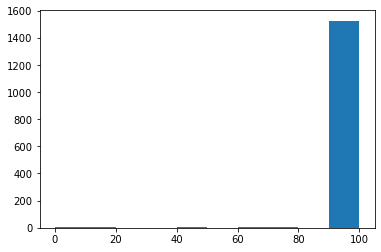

In [8]:
plt.hist(df['%Sand'][np.isfinite(df['%Sand'])])

#### Make a quick plot to view distribution of 'percent coarse'

(array([4., 2., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([26. , 27.9, 29.8, 31.7, 33.6, 35.5, 37.4, 39.3, 41.2, 43.1, 45. ]),
 <BarContainer object of 10 artists>)

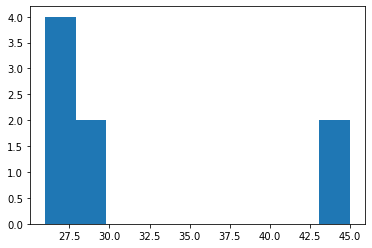

In [9]:
plt.hist(df['%Coarse'][np.isfinite(df['%Coarse'])])

#### Make a quick plot to view distribution of 'percent cohesive'

(array([4., 0., 0., 0., 2., 0., 0., 0., 0., 2.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

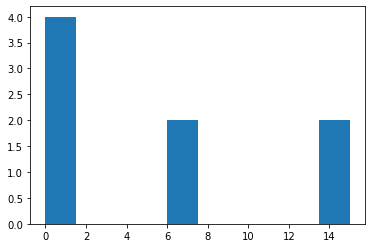

In [10]:
plt.hist(df['%Cohesive'][np.isfinite(df['%Cohesive'])])

### Output to file

Finally, define a csv file name for the output dataframe

In [11]:
output_csvfile='../data_plus_fractions.csv'

write the data to that csv file

In [12]:
df.to_csv(output_csvfile) #convert data to CSV